In [51]:
import pandas as pd
import datetime
from sklearn.neural_network import MLPClassifier
import random
import torch
from net import gtnet
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pickle
import os
from mpl_chord_diagram import chord_diagram

In [52]:
def normalize_matrix(matrix):
    # min_val = np.min(matrix)
    # max_val = np.max(matrix)
    # normalized_matrix = (matrix - min_val) / (max_val - min_val)
    for i in range(matrix.shape[0]):
        num1 = matrix[-1, i]
        num2 = matrix[i, -1]
        if num1 + num2 == 0:
            print('no flow', i)
            continue
        num1 = num1 / (num1 + num2)
        num2 = num2 / (num1 + num2)
        matrix[-1, i] = num1
        matrix[i, -1] = num2
    return matrix
def feature_ratio_rank(adj, features):
    lst = []
    for i in range(adj.shape[0]):
        outflow = adj[-1, i]
        outflow = 1
        inflow = adj[i, -1]
        if outflow == 0:
            ratio = 0
        else:
            ratio = inflow / outflow

        lst.append((features[i], ratio))
    return sorted(lst, key=lambda x: x[1])
def plot_heatmap(adj_lst, adj_name_lst, features, name):
    mat = np.zeros((len(features), len(adj_lst)))
    for count, adj in enumerate(adj_lst):
        inflow = adj[:, -1].copy()
        mat[:, count] = inflow

    mat = mat[:-1, :]
    cm_df = pd.DataFrame(mat,   
                    index = features[:-1], 
                    columns = adj_name_lst)
    
    plt.figure(figsize=(len(adj_lst), 0.3*len(features)))
    blue_cmap = sns.color_palette("Blues", as_cmap=True)
    sns.heatmap(cm_df, annot=True, cmap=blue_cmap)
    
    plt.gca().xaxis.tick_top()
    plt.xticks(rotation=90)
    # plt.show()
    plt.savefig(
        f"/storage/home/ruizhu/results/{name}.jpg",
        dpi=600, transparent=True, bbox_inches='tight',
        pad_inches=0.02)
def plot_chord_diff(adj1, adj2, features, name):
    
    grd = ( False)               # gradient
    gap  =  0                      # gap value
    srt = ( "distance")    # sort type
    cc = ( None)           # chord colors
    nr = (True)                # name rotation
    # cm = custom_colormap()
    cm = (plt.get_cmap('jet') )  
    # cm = None# colormap
    fclrs = "black"                                    # fontcolors
    d = (True)
    adj = adj2-adj1
    mask = np.zeros(shape=adj.shape)
    mask[:,-1] = 1
    mask[-1,:] = 1
    adj[mask==0] = 0
    inflow = adj[:, -1].copy()
    outflow = inflow.copy()
    inflow[inflow <= 0] = 0
    outflow[outflow >= 0] = 0
    outflow = abs(outflow)
    adj[:, -1] = inflow
    adj[-1, :] = outflow
    
    # args = (grads, gaps, sorts, cclrs, nrota, cmaps, drctd)
    # for grd, gap, srt, cc, nr, cm, d in zip(*args):
    chord_diagram(adj, features, gap=gap, use_gradient=grd, sort=srt, directed=d,
                  cmap=cm, chord_colors=cc, rotate_names=nr, fontcolor=fclrs)
    
    str_grd = "_gradient" if grd else ""
    
    plt.savefig(
        f"/storage/home/ruizhu/results/{name}.jpg",
        dpi=600, transparent=True, bbox_inches='tight',
        pad_inches=0.02)
def plot_chord(adj, features, name):
    grd = ( False)               # gradient
    gap  =  0                      # gap value
    srt = ( "distance")    # sort type
    cc = ( None)           # chord colors
    nr = (True)                # name rotation
    # cm = custom_colormap()
    # cm = (plt.get_cmap('jet') )  
    cm = None# colormap
    fclrs = "black"                                    # fontcolors
    d = (True)
    mask = np.zeros(shape=adj.shape)
    mask[:,-1] = 1
    mask[-1,:] = 1
    adj[mask==0] = 0
    # args = (grads, gaps, sorts, cclrs, nrota, cmaps, drctd)
    # for grd, gap, srt, cc, nr, cm, d in zip(*args):
    chord_diagram(adj, features, gap=gap, use_gradient=grd, sort=srt, directed=d,
                  cmap=cm, chord_colors=cc, rotate_names=nr, fontcolor=fclrs)
    
    str_grd = "_gradient" if grd else ""
    
    plt.savefig(
        f"/storage/home/ruizhu/results/{name}.jpg",
        dpi=600, transparent=True, bbox_inches='tight',
        pad_inches=0.02)

no flow 16


/h/ruizhu/.conda/envs/pt-2/lib/python3.8/site-packages/mpl_chord_diagram/utilities.py:167: RuntimeWarning: invalid value encountered in divide
  return (mat[i, :] / x[i]) * (end - start)


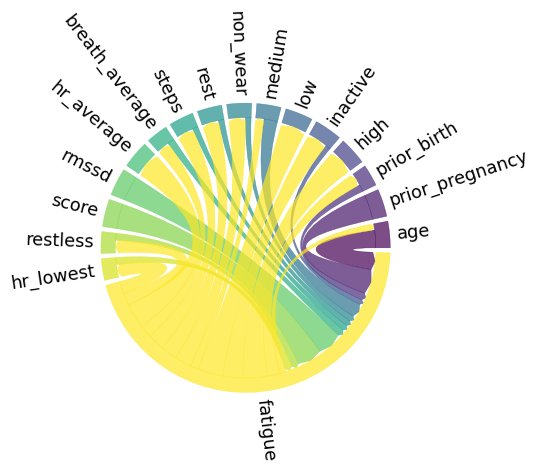

In [53]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
model_name = 'MTGNN'
slice_num = 2
symptom = 'fatigue'
# run_num = 1
symptom_weight = 1.0
symptom_weight_str = str(symptom_weight).replace('.', 'dot')
adv_weight = 0.0
adv_weight_str = str(adv_weight).replace('.', 'dot')

features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
suffix = 'xydiffw'
adj_lst = []
for run_num in range(5):
    pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl'
    with open(os.path.join(root_path, pkl_name), 'rb') as f:
        data = pickle.load(f)
        adj = data[list(data.keys())[0]][2][0]
        adj_lst.append(adj)

stacked_arrays = np.stack(adj_lst)
mean_adj_MTGNN = normalize_matrix(np.mean(stacked_arrays, axis=0))
# cm_df = pd.DataFrame(mean_adj,   
#                     index = features, 
#                     columns = features)

#         #Plotting the confusion matrix
# plt.figure(figsize=(9,9))
# sns.heatmap(cm_df, annot=True)
# plt.show()

plot_chord(mean_adj_MTGNN, features, f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl')

In [54]:
# mean_adj_MTGNN
# cm_df = pd.DataFrame(mean_adj_MTGNN,   
#                     index = features, 
#                     columns = features)

# #Plotting the confusion matrix
# plt.figure(figsize=(9,9))
# sns.heatmap(cm_df, annot=True)
# plt.show()

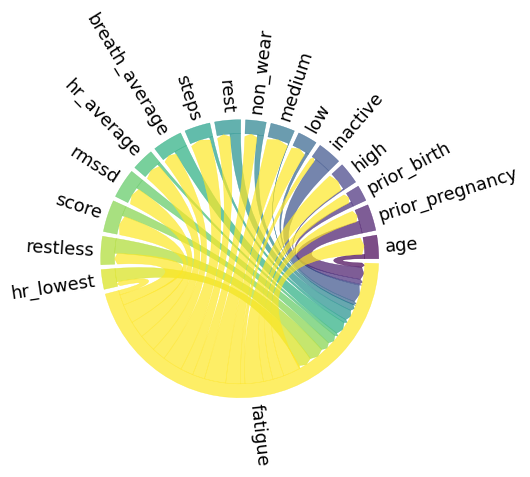

In [55]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
model_name = 'MTGNN_lstm'
slice_num = 2
symptom = 'fatigue'
# run_num = 1
symptom_weight = 1.0
symptom_weight_str = str(symptom_weight).replace('.', 'dot')
adv_weight = 0.0
adv_weight_str = str(adv_weight).replace('.', 'dot')

features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
suffix = 'xydiffw'
adj_lst = []
for run_num in range(5):
    pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl'
    with open(os.path.join(root_path, pkl_name), 'rb') as f:
        data = pickle.load(f)
        for k in data.keys():
            adj = data[k][2][0]
            adj_lst.append(adj)

stacked_arrays = np.stack(adj_lst)
mean_adj_MTGNN_lstm = normalize_matrix(np.mean(stacked_arrays, axis=0))
# cm_df = pd.DataFrame(mean_adj,   
#                     index = features, 
#                     columns = features)

#         #Plotting the confusion matrix
# plt.figure(figsize=(9,9))
# sns.heatmap(cm_df, annot=True)
# plt.show()

plot_chord(mean_adj_MTGNN_lstm, features, f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl')

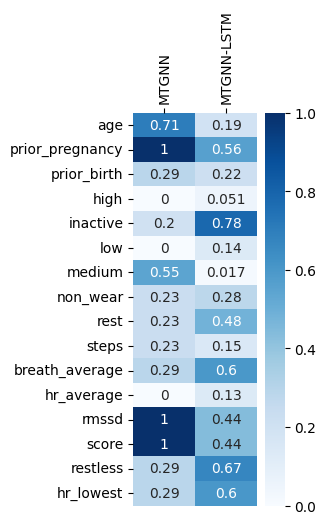

In [56]:
plot_heatmap([mean_adj_MTGNN, mean_adj_MTGNN_lstm], ['MTGNN', 'MTGNN-LSTM'], features, 'heatmap_figure2')

/h/ruizhu/.conda/envs/pt-2/lib/python3.8/site-packages/mpl_chord_diagram/utilities.py:167: RuntimeWarning: invalid value encountered in divide
  return (mat[i, :] / x[i]) * (end - start)


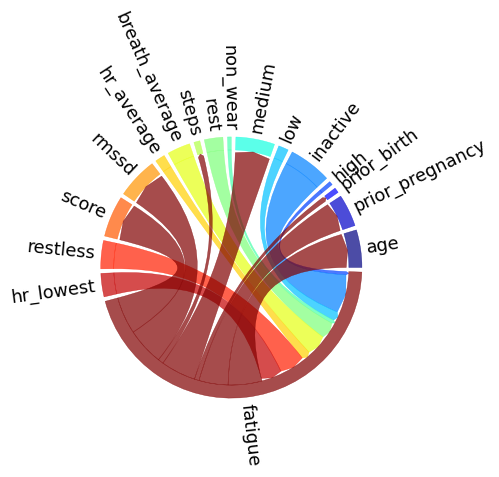

In [57]:
plot_chord_diff(mean_adj_MTGNN, mean_adj_MTGNN_lstm, features, 'figure2')
# plot_chord(mean_adj_MTGNN_lstm-mean_adj_MTGNN, features, 'figure2')

no flow 16


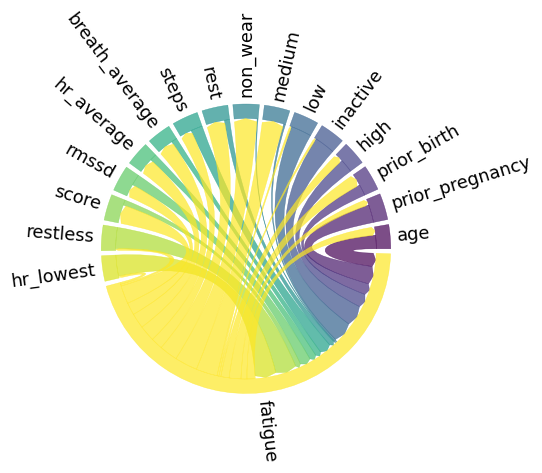

In [58]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
model_name = 'MTGNN'
slice_num = 0
symptom = 'fatigue'
# run_num = 1
symptom_weight = 1.0
symptom_weight_str = str(symptom_weight).replace('.', 'dot')
adv_weight = 0.0
adv_weight_str = str(adv_weight).replace('.', 'dot')

features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
suffix = 'xydiffw'
adj_lst = []
for run_num in range(5):
    pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl'
    with open(os.path.join(root_path, pkl_name), 'rb') as f:
        data = pickle.load(f)
        for k in data.keys():
            adj = data[k][2][0]
            adj_lst.append(adj)

stacked_arrays = np.stack(adj_lst)
mean_adj_MTGNN = normalize_matrix(np.mean(stacked_arrays, axis=0))
plot_chord(mean_adj_MTGNN, features, f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl')

no flow 16


/h/ruizhu/.conda/envs/pt-2/lib/python3.8/site-packages/mpl_chord_diagram/utilities.py:167: RuntimeWarning: invalid value encountered in divide
  return (mat[i, :] / x[i]) * (end - start)


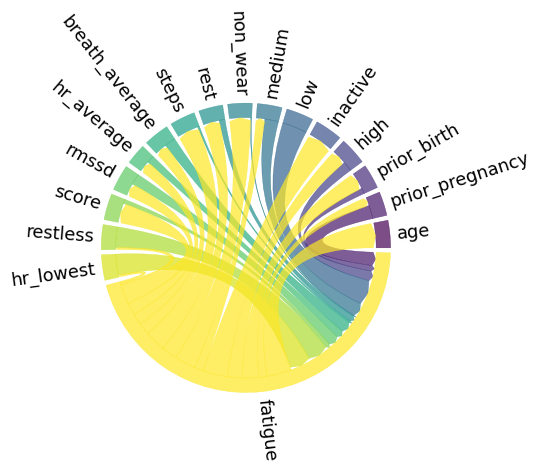

In [59]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
model_name = 'MTGNN'
slice_num = 0
symptom = 'fatigue'
# run_num = 1
symptom_weight = 1.1
symptom_weight_str = str(symptom_weight).replace('.', 'dot')
adv_weight = 0.0
adv_weight_str = str(adv_weight).replace('.', 'dot')

features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
suffix = 'xydiffw'
adj_lst = []
for run_num in range(5):
    pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl'
    with open(os.path.join(root_path, pkl_name), 'rb') as f:
        data = pickle.load(f)
        for k in data.keys():
            adj = data[k][2][0]
            adj_lst.append(adj)

stacked_arrays = np.stack(adj_lst)
mean_adj_MTGNN_sym = normalize_matrix(np.mean(stacked_arrays, axis=0))
plot_chord(mean_adj_MTGNN_sym, features, f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl')

no flow 16


/h/ruizhu/.conda/envs/pt-2/lib/python3.8/site-packages/mpl_chord_diagram/utilities.py:167: RuntimeWarning: invalid value encountered in divide
  return (mat[i, :] / x[i]) * (end - start)


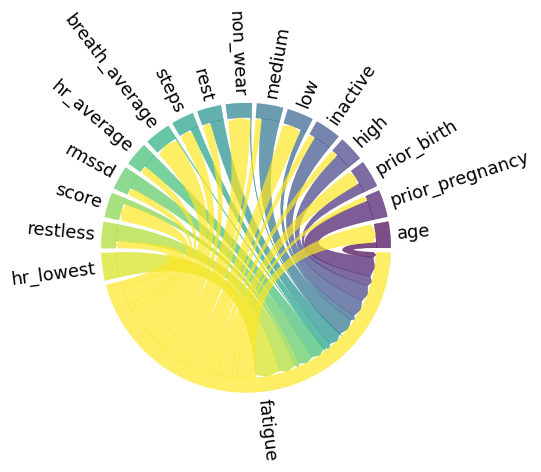

In [60]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
model_name = 'MTGNN'
slice_num = 0
symptom = 'fatigue'
# run_num = 1
symptom_weight = 1.0
symptom_weight_str = str(symptom_weight).replace('.', 'dot')
adv_weight = 0.003
adv_weight_str = str(adv_weight).replace('.', 'dot')

features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
suffix = 'xydiffw'
adj_lst = []
for run_num in range(5):
    pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl'
    with open(os.path.join(root_path, pkl_name), 'rb') as f:
        data = pickle.load(f)
        for k in data.keys():
            adj = data[k][2][0]
            adj_lst.append(adj)

stacked_arrays = np.stack(adj_lst)
mean_adj_MTGNN_adv = normalize_matrix(np.mean(stacked_arrays, axis=0))
plot_chord(mean_adj_MTGNN_adv, features, f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_adv{adv_weight_str}_sym{symptom_weight_str}_{suffix}.pkl')

/h/ruizhu/.conda/envs/pt-2/lib/python3.8/site-packages/mpl_chord_diagram/utilities.py:167: RuntimeWarning: invalid value encountered in divide
  return (mat[i, :] / x[i]) * (end - start)


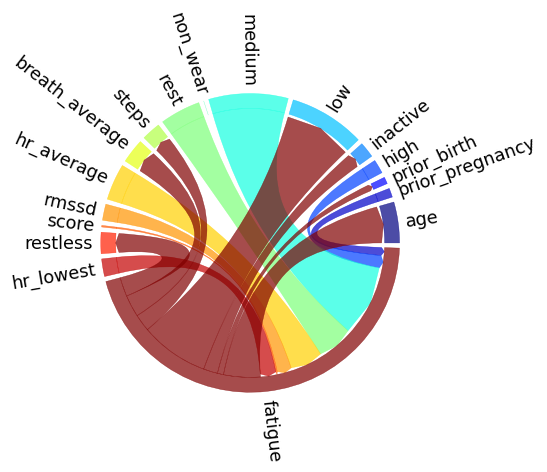

In [61]:
plot_chord_diff(mean_adj_MTGNN, mean_adj_MTGNN_adv, features, 'figure1-adv-baseline')


/h/ruizhu/.conda/envs/pt-2/lib/python3.8/site-packages/mpl_chord_diagram/utilities.py:167: RuntimeWarning: invalid value encountered in divide
  return (mat[i, :] / x[i]) * (end - start)


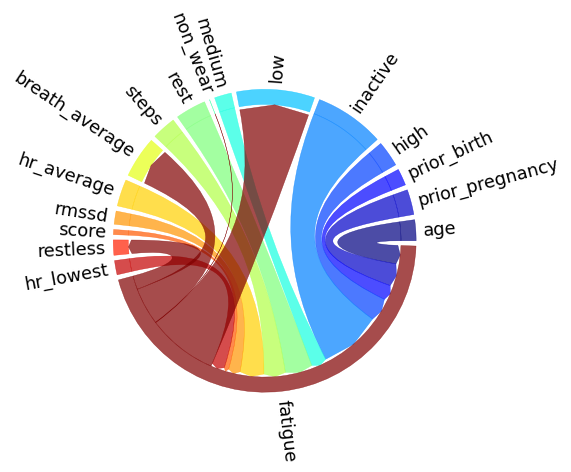

In [62]:
plot_chord_diff(mean_adj_MTGNN_sym, mean_adj_MTGNN_adv, features, 'figure1-adv-sym')


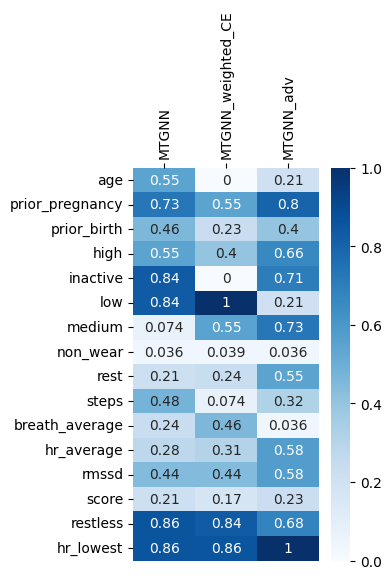

In [63]:
plot_heatmap([mean_adj_MTGNN, mean_adj_MTGNN_sym, mean_adj_MTGNN_adv], ['MTGNN', 'MTGNN_weighted_CE', 'MTGNN_adv'], features, 'heatmap_figure1')

no flow 16
('edema', 0.0)
('hr_lowest', 0.06896551698446274)
('restless', 0.07079646736383438)
('breath_average', 0.15730339288711548)
('score', 0.1818181425333023)
('hr_average', 0.18181820213794708)
('inactive', 0.23076924681663513)
('medium', 0.24242424964904785)
('non_wear', 0.2857145667076111)
('high', 0.29530203342437744)
('rest', 0.3243243396282196)
('prior_birth', 0.4680851101875305)
('low', 0.5454359650611877)
('rmssd', 0.6153846383094788)
('age', 0.6268656849861145)
('prior_pregnancy', 0.7368420362472534)
('steps', 0.7368420958518982)


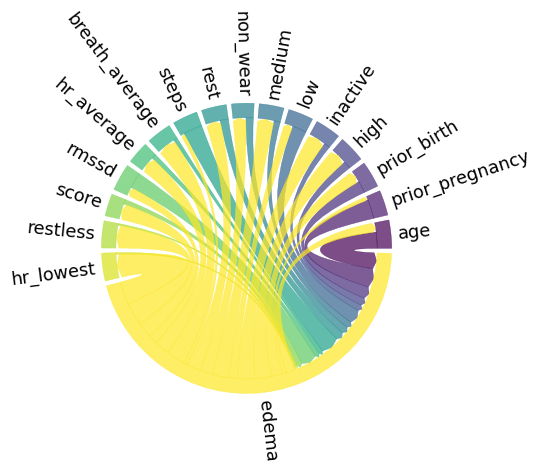

In [64]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
model_name = 'MTGNN'
symptom = 'edema'
# run_num = 1
symptom_weight = [1.1, 1.3, 1.3]
symptom_weight_str = [str(s).replace('.', 'dot') for s in symptom_weight]
adv_weight = 0.0
adv_weight_str = str(adv_weight).replace('.', 'dot')

features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
suffix = 'xydiffw'
adj_lst = []
for slice_num in range(3):
    for run_num in range(5):
        pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_adv{adv_weight_str}_sym{symptom_weight_str[slice_num]}_{suffix}.pkl'
        with open(os.path.join(root_path, pkl_name), 'rb') as f:
            data = pickle.load(f)
            adj = data[list(data.keys())[0]][2][0]
            adj_lst.append(adj)

stacked_arrays = np.stack(adj_lst)
edema_mean_adj = normalize_matrix(np.mean(stacked_arrays, axis=0))
# cm_df = pd.DataFrame(mean_adj,   
#                     index = features, 
#                     columns = features)

#         #Plotting the confusion matrix
# plt.figure(figsize=(9,9))
# sns.heatmap(cm_df, annot=True)
# plt.show()

plot_chord(edema_mean_adj, features, f'{model_name}_MTGNN_weight_{symptom}_analysis_3rd_trend_{suffix}.pkl')

for i in feature_ratio_rank(edema_mean_adj, features):
    print(i)

no flow 16
('fatigue', 0.0)
('age', 0.146341472864151)
('hr_average', 0.1509428471326828)
('prior_birth', 0.21052491664886475)
('breath_average', 0.22222183644771576)
('score', 0.25925928354263306)
('rest', 0.28571394085884094)
('non_wear', 0.33333343267440796)
('inactive', 0.3478245735168457)
('high', 0.3793112337589264)
('steps', 0.3999769985675812)
('medium', 0.42857152223587036)
('low', 0.4444444477558136)
('restless', 0.4444757103919983)
('hr_lowest', 0.47058823704719543)
('prior_pregnancy', 0.5620439052581787)
('rmssd', 0.5620443820953369)


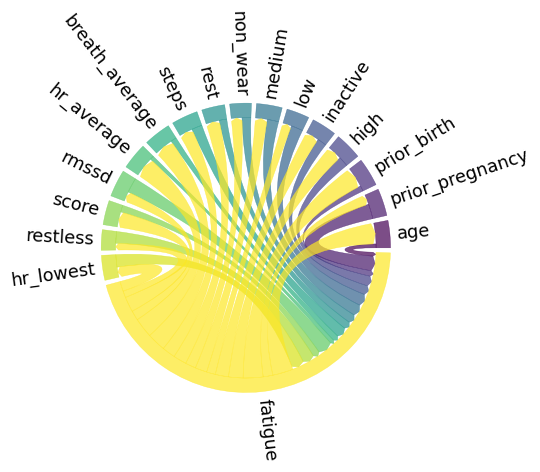

In [65]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
model_name = 'MTGNN'
symptom = 'fatigue'
# run_num = 1
symptom_weight = [1.1, 1.1, 1.1]
symptom_weight_str = [str(s).replace('.', 'dot') for s in symptom_weight]
adv_weight = 0.0
adv_weight_str = str(adv_weight).replace('.', 'dot')

features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
suffix = 'xydiffw'
adj_lst = []
for slice_num in range(3):
    for run_num in range(5):
        pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_adv{adv_weight_str}_sym{symptom_weight_str[slice_num]}_{suffix}.pkl'
        with open(os.path.join(root_path, pkl_name), 'rb') as f:
            data = pickle.load(f)
            adj = data[list(data.keys())[0]][2][0]
            adj_lst.append(adj)

stacked_arrays = np.stack(adj_lst)
fatigue_mean_adj = normalize_matrix(np.mean(stacked_arrays, axis=0))
# cm_df = pd.DataFrame(mean_adj,   
#                     index = features, 
#                     columns = features)

#         #Plotting the confusion matrix
# plt.figure(figsize=(9,9))
# sns.heatmap(cm_df, annot=True)
# plt.show()


plot_chord(fatigue_mean_adj, features, f'{model_name}_MTGNN_weight_{symptom}_analysis_3rd_trend_{suffix}.pkl')
for i in feature_ratio_rank(fatigue_mean_adj, features):
    print(i)

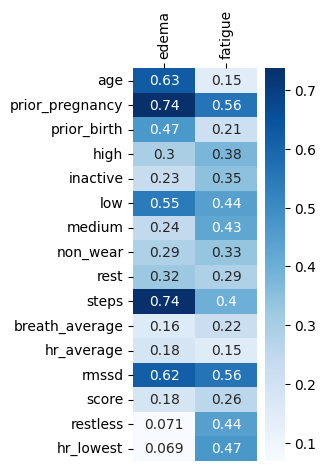

In [66]:
features[-1] = 'subjective symptom'
plot_heatmap([edema_mean_adj, fatigue_mean_adj], ['edema', 'fatigue'], features, 'overall_heatmap')

no flow 16
no flow 16
no flow 16
no flow 16
no flow 16
no flow 16
no flow 16
no flow 16
no flow 16


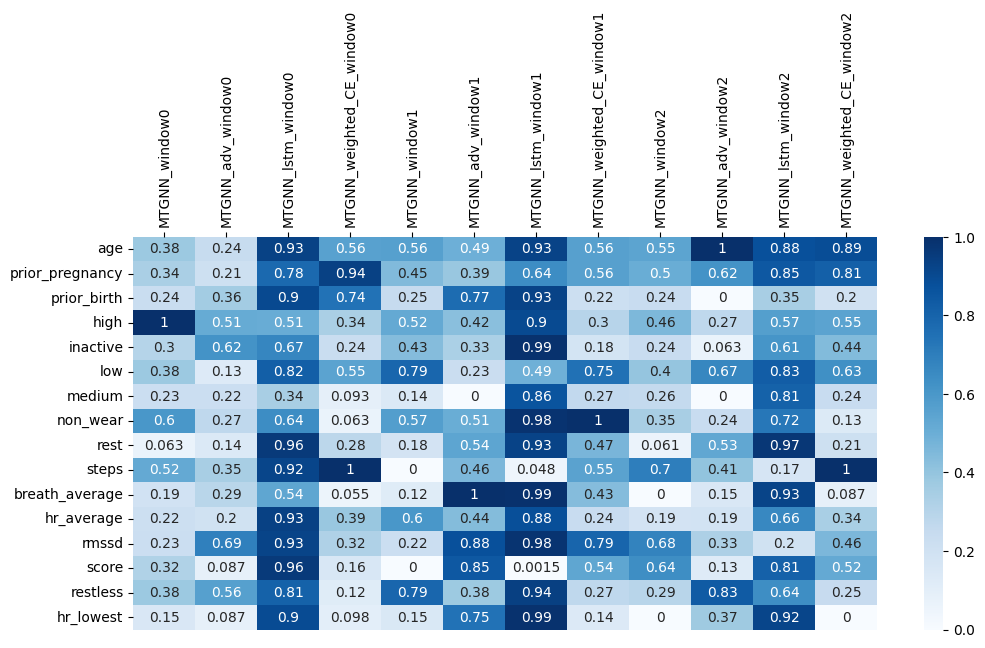

In [77]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
models = ['MTGNN', 'MTGNN', 'MTGNN_lstm', 'MTGNN']
symptom_weight_lst = [
    [1.0, 1.0, 1.0, 1.1],
    [1.0, 1.0, 1.0, 1.3],
    [1.0, 1.0, 1.0, 1.3]
]
adv_weight_lst = [
    [0.0,0.003,0.0,0.0],
    [0.0,0.003,0.0,0.0],
    [0.0,0.003,0.0,0.0],
]
actual_model_name = ['MTGNN', 'MTGNN_adv', 'MTGNN_lstm', 'MTGNN_weighted_CE']
all_adj_lst = []
all_adj_name_lst = []

symptom = 'edema'
for slice_num in range(3):
    for count, model_name in enumerate(models):
        symptom_weight = symptom_weight_lst[slice_num]
        symptom_weight_str = [str(s).replace('.', 'dot') for s in symptom_weight]
        adv_weight = adv_weight_lst[slice_num]
        adv_weight_str = [str(s).replace('.', 'dot') for s in adv_weight]
        
        features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
            'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
        suffix = 'xydiffw'
        adj_lst = []
    
        for run_num in range(5):
            pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_adv{adv_weight_str[count]}_sym{symptom_weight_str[count]}_{suffix}.pkl'
            with open(os.path.join(root_path, pkl_name), 'rb') as f:
                data = pickle.load(f)
                for k in data.keys():
                    adj = data[k][2][0]
                    adj_lst.append(adj)
    
        stacked_arrays = np.stack(adj_lst)
        all_adj_lst.append(normalize_matrix(np.mean(stacked_arrays, axis=0)))
        all_adj_name_lst.append(f'{actual_model_name[count]}_window{slice_num}')

# plot_chord(fatigue_mean_adj, features, f'{model_name}_MTGNN_weight_{symptom}_analysis_3rd_trend_{suffix}.pkl')
plot_heatmap(all_adj_lst, all_adj_name_lst, features, 'appendix_edema')

no flow 16
no flow 16
no flow 16
no flow 16
no flow 16
no flow 16
no flow 16
no flow 16
no flow 16


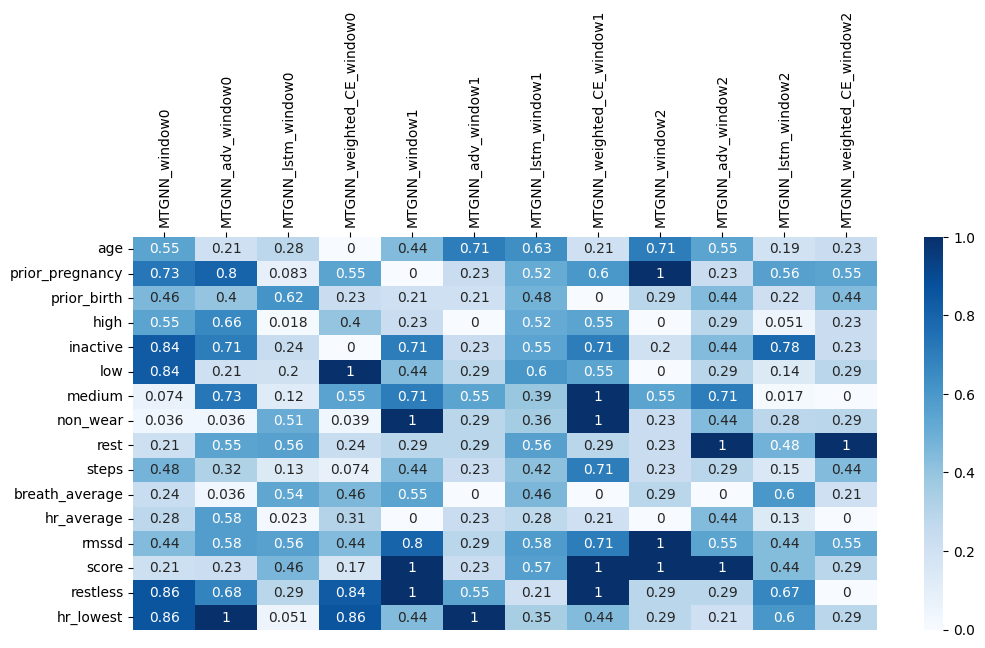

In [78]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
models = ['MTGNN', 'MTGNN', 'MTGNN_lstm', 'MTGNN']
symptom_weight_lst = [
    [1.0, 1.0, 1.0, 1.1],
    [1.0, 1.0, 1.0, 1.1],
    [1.0, 1.0, 1.0, 1.1]
]
adv_weight_lst = [
    [0.0,0.003,0.0,0.0],
    [0.0,0.007,0.0,0.0],
    [0.0,0.003,0.0,0.0],
]
actual_model_name = ['MTGNN', 'MTGNN_adv', 'MTGNN_lstm', 'MTGNN_weighted_CE']
all_adj_lst = []
all_adj_name_lst = []

symptom = 'fatigue'
for slice_num in range(3):
    for count, model_name in enumerate(models):
        symptom_weight = symptom_weight_lst[slice_num]
        symptom_weight_str = [str(s).replace('.', 'dot') for s in symptom_weight]
        adv_weight = adv_weight_lst[slice_num]
        adv_weight_str = [str(s).replace('.', 'dot') for s in adv_weight]
        
        features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
            'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
        suffix = 'xydiffw'
        adj_lst = []
    
        for run_num in range(5):
            pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_adv{adv_weight_str[count]}_sym{symptom_weight_str[count]}_{suffix}.pkl'
            with open(os.path.join(root_path, pkl_name), 'rb') as f:
                data = pickle.load(f)
                for k in data.keys():
                    adj = data[k][2][0]
                    adj_lst.append(adj)
    
        stacked_arrays = np.stack(adj_lst)
        all_adj_lst.append(normalize_matrix(np.mean(stacked_arrays, axis=0)))
        all_adj_name_lst.append(f'{actual_model_name[count]}_window{slice_num}')

# plot_chord(fatigue_mean_adj, features, f'{model_name}_MTGNN_weight_{symptom}_analysis_3rd_trend_{suffix}.pkl')
plot_heatmap(all_adj_lst, all_adj_name_lst, features, 'appendix_fatigue')

In [71]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
model_name = 'MTGNN'
slice_num = 2
symptom = 'fatigue'
run_num = 1
features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
suffix = 'xydiffw'
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_{suffix}.pkl'
def read_pkl(root_path, pkl_name):
    with open(os.path.join(root_path, pkl_name), 'rb') as f:
        data = pickle.load(f)
        
        for k in sorted(data):
            pred = data[k][0].squeeze()
            target_values = [0, 0.2, 0.4, 0.8, 1, 1.2]
            pred = [min(target_values, key=lambda x: abs(x - num)) for num in pred]
            # true = (data[k][1]>0).astype(int).squeeze()
            true = data[k][1].squeeze()
            if np.sum(pred) == 0 and np.sum(true) == 0:
                print('participant:', k)
                print('pred:', pred)
                print('true:', true)
            else:
                print('participant:', k)
                print('pred:', pred)
                print('true:', true)

def plot_adj(root_path, pkl_name, user_id, features):
    with open(os.path.join(root_path, pkl_name), 'rb') as f:
        data = pickle.load(f)
        adj = data[user_id][2][0]
        cm_df = pd.DataFrame(adj,   
                    index = features, 
                    columns = features)

        #Plotting the confusion matrix
        plt.figure(figsize=(9,9))
        sns.heatmap(cm_df, annot=True)
        plt.show()
# read_pkl(root_path, pkl_name)

In [70]:
model_name = 'GNN'
slice_num = 2
symptom = 'fatigue'
run_num = 0
suffix='xydiffw'
features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_missingness_run{run_num}.pkl'
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_{suffix}.pkl'

# read_pkl(root_path, pkl_name)

In [44]:
model_name = 'MTGNN'
slice_num = 2
symptom = 'fatigue'
run_num = 3
suffix='now'
features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_missingness_run{run_num}.pkl'
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_{suffix}.pkl'

# read_pkl(root_path, pkl_name)

In [45]:
model_name = 'MTGNN'
slice_num = 0
symptom = 'edema'
run_num = 0
suffix='xydiffw'
features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_missingness_run{run_num}.pkl'
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_{suffix}.pkl'

read_pkl(root_path, pkl_name)

NameError: name 'read_pkl' is not defined

In [46]:
model_name = 'MTGNN'
slice_num = 0
symptom = 'edema'
run_num = 0
suffix='now'
features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_missingness_run{run_num}.pkl'
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_trend_run{run_num}_{suffix}.pkl'

# read_pkl(root_path, pkl_name)

In [47]:
model_name = 'LSTM'
slice_num = 3
symptom = 'fatigue'
run_num = 2
features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_missingness_run{run_num}.pkl'

# read_pkl(root_path, pkl_name)

In [48]:
root_path = '/storage/home/ruizhu/results/error_analysis/'
model_name = 'MTGNN'
slice_num = 2
symptom = 'fatigue'
run_num = 4
features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_missingness_run{run_num}.pkl'

# read_pkl(root_path, pkl_name)
# plot_adj(root_path, pkl_name, 2592, features)

In [49]:
model_name = 'MTGNN_lstm'
slice_num = 1
symptom = 'edema'
run_num = 0
features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_missingness_run{run_num}.pkl'

# read_pkl(root_path, pkl_name)
# plot_adj(root_path, pkl_name, 190, features)

In [50]:
model_name = 'LSTM'
slice_num = 1
symptom = 'edema'
run_num = 0
features = ['age', 'prior_pregnancy', 'prior_birth', 'high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',symptom]
pkl_name = f'{model_name}_slice{slice_num}_{symptom}_analysis_3rd_missingness_run{run_num}.pkl'

# read_pkl(root_path, pkl_name)

In [77]:
# model = torch.load(f'/mnt/results/model/model_all_pop_edema_0_advweight_0_GNN_advTrue_slice0.pt')
# model_path = f'/storage/home/ruizhu/results/model/model_all_feat_0_advweight_0dot0_popnormTrue_slices0_GNN_advTrue_slice0_edema_analysis_3rd.pt'
# model_path = "/storage/home/ruizhu/results/model/model_all_feat_0_advweight_0_popnormTrue_slices0_symptom_weight1_fakelabelFalse_GNN_advTrue_slice0_fatigue_analysis_3rd.pt"

model_path = '/storage/home/ruizhu/results/model/model_all_feat_3_advweight_0dot0_popnormTrue_slices0_symptom_weight1dot0_fakelabelFalse_GNN_advTrue_slice0_edema_analysis_3rd.pt'
# model_path = "/storage/home/ruizhu/results/model/model_all_feat_0_advweight_0dot7_popnormTrue_slices3_GNN_advTrue_slice3_edema_analysis_3rd.pt"

curr_slice = 3
model = torch.load(model_path)
# model.state_dict
model_path.split('/')[-1].split('.')[0]

'model_all_feat_3_advweight_0dot0_popnormTrue_slices0_symptom_weight1dot0_fakelabelFalse_GNN_advTrue_slice0_edema_analysis_3rd'

In [78]:
all_adj = np.zeros((14, 14))
for i in range(5):
    model_path = f'/storage/home/ruizhu/results/model/model_all_feat_{i}_advweight_0_popnormTrue_slices3_symptom_weight1_fakelabelFalse_GNN_advTrue_slice3_fatigue_analysis_3rd.pt'
    model = torch.load(model_path)
    model.eval()
    adj = model.gc.fullA(model.idx).cpu().detach().numpy()
    all_adj += adj
mask = np.zeros(shape=all_adj.shape)
mask[:,-1] = 1
mask[-1,:] = 1
all_adj[mask==0] = 0

In [79]:
model.eval()
model.idx
# for p in model.parameters():
#     print(p.nelement())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       device='cuda:0')

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [80]:
adj = model.gc(model.idx).cpu().detach().numpy()
adj = model.gc.fullA(model.idx).cpu().detach().numpy()

In [81]:
model.gc.k

5

In [82]:
model.gc.fullA(model.idx).shape

torch.Size([14, 14])

In [69]:
# features = ['Active calories','Calories','Daily movement','Minutes of high-intensity activity','Minutes of inactive','Minutes of low-intensity activity','Minutes of medium-intensity activity','High-intensity MET','Inactive MET','Low-intensity MET','Medium-intensity MET','Minutes of non-wear','Minutes of rest','Total daily steps','Impedance magnitude','Impedance phase','Weight','Respiratory rate','Edema']
n = model_path.split('/')[-1].split('.')[0]
# features = ['Impedance magnitude','Impedance phase','Weight','Calories','Daily movement','Minutes of high-intensity activity','Minutes of inactive','Minutes of low-intensity activity','Minutes of medium-intensity activity','Minutes of non-wear','Minutes of rest','Total daily steps','Respiratory rate','Edema']
if "edema" in model_path:
    last_feature = "edema"
else:
    last_feature = "fatigue"
features = ['high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','restless','hr_lowest',last_feature]
def analysis_result(mat, features):
    cm_df = pd.DataFrame(mat,   
                    index = features, 
                    columns = features)

    #Plotting the confusion matrix
    plt.figure(figsize=(9,9))
    sns.heatmap(cm_df, annot=True)
    plt.savefig(f'/storage/home/ruizhu/results/plots/adj_{n}.svg')
    plt.show()
# analysis_result(adj, features)

NameError: name 'model_path' is not defined

/h/ruizhu/.conda/envs/pt-2/lib/python3.8/site-packages/mpl_chord_diagram/utilities.py:167: RuntimeWarning: invalid value encountered in divide
  return (mat[i, :] / x[i]) * (end - start)


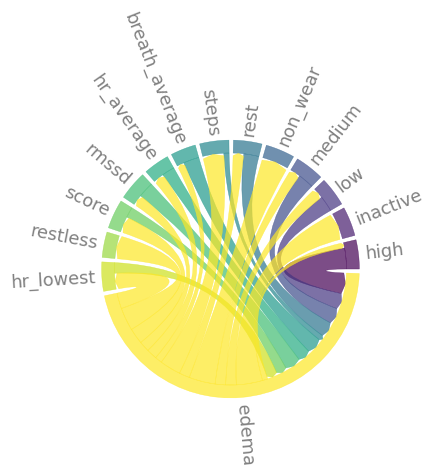

In [100]:
grd = ( False)               # gradient
gap  =  0                        # gap value
srt = ( "distance")    # sort type
cc = ( None)           # chord colors
nr = (True)                # name rotation
cm = (None)              # colormap
fclrs = "grey"                                    # fontcolors
d = (True)
mask = np.zeros(shape=adj.shape)
mask[:,-1] = 1
mask[-1,:] = 1
adj[mask==0] = 0
# args = (grads, gaps, sorts, cclrs, nrota, cmaps, drctd)
# for grd, gap, srt, cc, nr, cm, d in zip(*args):
chord_diagram(all_adj, features, gap=gap, use_gradient=grd, sort=srt, directed=d,
              cmap=cm, chord_colors=cc, rotate_names=nr, fontcolor=fclrs)

str_grd = "_gradient" if grd else ""

plt.savefig(
    f"/storage/home/ruizhu/results/chord_{n}.jpg",
    dpi=600, transparent=True, bbox_inches='tight',
    pad_inches=0.02)

AssertionError: datasets should not be an empty iterable